In [1]:
import geopandas as gpd
import psycopg2
import yaml
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, GroupShuffleSplit, GroupKFold, StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, make_scorer, recall_score, precision_score, RocCurveDisplay
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import seaborn as sns
import pickle


c:\Users\kylershu\.conda\envs\dssg_dev\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def read_yaml(file_path):
    """
    read in config file.  All options and adjustments should be made to config file.
    input: yaml file path
    output: dictionary
    """
    with open(file_path, "r") as f:
        return yaml.safe_load(f)

In [3]:
# reading in char alerts data
conn_creds = read_yaml('C:\\DSSG_CHAR\\Configs\\db_conn.yaml')

connection = psycopg2.connect(
    dbname=conn_creds['dbname'],
    user=conn_creds['user'],
    password=conn_creds['password'],
    host=conn_creds['address']
)
'''
sql = {}
sql['select'] = "SELECT g.id, g.feature_type, g.properties, s.adm_level, s.adm_name, s.geometry"
sql['from'] = "FROM geospatial_view as g"
sql['join'] = "JOIN adm_division as s"
sql['on'] = "ON ST_intersects(g.wkb_geometry, s.geometry)"
sql['where'] = "WHERE s.adm_name = 'Cerrado' and g.feature_type = 'watermass'"
sql['limit'] = "LIMIT 500;"
sql_text = ' '.join(sql.values())
'''
sql_text = "SELECT * FROM char_alerts;"
df = gpd.GeoDataFrame.from_postgis(sql_text, connection, geom_col='geometry')

c:\Users\kylershu\.conda\envs\dssg_dev\Lib\site-packages\geopandas\io\sql.py:185: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(


In [4]:
# creating unique x_tile y_tile combination for spatial grouping
df['loc'] = df['x_tile'].astype(str) + ',' + df['y_tile'].astype(str)
df['loc'].value_counts()
df["validation"] = df["validation"].apply(lambda x: 1 if x else 0)

In [5]:
df_all = pd.read_parquet(r'c:\DSSG_CHAR\Intermediate_Data_Sets\all_distances.parquet')
df = df.merge(df_all, on='geo_id')
df.columns

Index(['geo_id', 'x_tile', 'y_tile', 'geo_month', 'geo_year', 'model_score',
       'validation', 'data_source', 'area', 'centroid', 'geometry', 'loc',
       'Distance to nearest rural road', 'Distance to nearest watermass',
       'Distance to nearest town', 'Distance to nearest vila',
       'Distance to nearest rural settlements',
       'Distance to nearest mineral extraction point',
       'Distance to nearest landing path', 'Distance to nearest island',
       'Distance to nearest densely infrastructured area',
       'Distance to nearest ibama embargo',
       'Distance to nearest indigenous lands',
       'Distance to nearest official roads',
       'Distance to nearest deforestation permit',
       'Distance to nearest biomas alert', 'Char alerts within 10km',
       'MPB alerts within 10km'],
      dtype='object')

In [6]:
# OLD DATA STUFF
'''
# number of deforestation alerts within a 10km radius
df_mpb_10km = pd.read_csv(r'c:\DSSG_CHAR\Intermediate_Data_Sets\biomas_count_to_char_alerts.csv')
df_mpb_10km = pd.DataFrame(df_mpb_10km['geo_id'].value_counts())
df = df.merge(df_mpb_10km, on='geo_id', how='left')
df['count']=df['count'].fillna(0)
'''

"\n# number of deforestation alerts within a 10km radius\ndf_mpb_10km = pd.read_csv(r'c:\\DSSG_CHAR\\Intermediate_Data_Sets\x08iomas_count_to_char_alerts.csv')\ndf_mpb_10km = pd.DataFrame(df_mpb_10km['geo_id'].value_counts())\ndf = df.merge(df_mpb_10km, on='geo_id', how='left')\ndf['count']=df['count'].fillna(0)\n"

In [6]:
# car registry + deforestation permits
df_car = pd.read_csv(r'c:\DSSG_CHAR\Intermediate_Data_Sets\car_deforest.csv')
df_car['car_status'] = df_car['ind_status'].apply(lambda x: 1 if x=='AT' else 0)
df_car['deforest_status'] = df_car['id'].apply(lambda x: 1 if pd.isnull(x) else 0)
df_car.groupby(by='validation')['car_status'].value_counts(), df_car.groupby('validation')['deforest_status'].value_counts()
df = df.merge(df_car[['geo_id', 'car_status', 'deforest_status']], on='geo_id')

In [7]:
df_smartlab = pd.read_parquet(r'c:\DSSG_CHAR\Intermediate_Data_Sets\smartlab_data.parquet')
df = df.merge(df_smartlab, on='geo_id')

In [8]:
# landover data, 12 category
df_landcover = pd.read_csv(r'c:\DSSG_CHAR\Intermediate_Data_Sets\mapbiomas_groups.csv')
df_landcover = df_landcover.rename(columns={"Group": "landcover", 'ID': "geo_id"})
df_landcover['landcover'] = df_landcover['landcover'].fillna('Unknown')
df = df.merge(df_landcover[['geo_id', 'landcover']], on="geo_id")

In [10]:
'''
embeddings = pd.read_parquet(r'c:\DSSG_CHAR\Intermediate_Data_Sets\embeddings.parquet')
df = df.merge(embeddings, on=['x_tile', 'y_tile', 'geo_month', 'geo_year'])
'''

"\nembeddings = pd.read_parquet(r'c:\\DSSG_CHAR\\Intermediate_Data_Sets\\embeddings.parquet')\ndf = df.merge(embeddings, on=['x_tile', 'y_tile', 'geo_month', 'geo_year'])\n"

In [11]:
# exploration / visualizations
#df[df['validation']==1]['distance_to_nearest_rural_road'].plot.hist(title='Distance to nearest rural road, TRUE POSITIVES', color='orange')
#df[df['validation']==0]['distance_to_nearest_rural_road'].plot.hist(title='Distance to nearest rural road, FALSE POSITIVES')
#df[df['validation']==1].sort_values(by= 'distance_to_nearest_rural_road', ascending=False).head(5)
#df.groupby('validation')['distance_to_nearest_rural_road'].plot.hist()
#df.groupby('validation')['area'].plot.hist()

In [12]:
coords = pd.read_csv(r'c:\DSSG_CHAR\Intermediate_Data_Sets\mosaiks\coordinates.csv')

In [13]:
mosaiks = pd.read_csv(r'c:\DSSG_CHAR\Intermediate_Data_Sets\mosaiks\coordinates\Mosaiks_features.csv')

In [14]:
from scipy.spatial import cKDTree

#coords.merge(mosaiks, left_on=['Y', 'X'], right_on=['Lat', 'Lon'])
gdf1 = gpd.GeoDataFrame(coords, geometry=gpd.points_from_xy(coords.Y, coords.X))
gdf2 = gpd.GeoDataFrame(mosaiks, geometry=gpd.points_from_xy(mosaiks.Lat, mosaiks.Lon))

# Extract the coordinates as NumPy arrays
coords1 = np.array(list(gdf1.geometry.apply(lambda geom: (geom.x, geom.y))))
coords2 = np.array(list(gdf2.geometry.apply(lambda geom: (geom.x, geom.y))))

# Create KDTree for fast spatial queries
tree = cKDTree(coords2)

# Query the closest point in gdf2 for each point in gdf1
distances, indices = tree.query(coords1, k=1)

# Create a DataFrame to hold the closest matches
closest_matches = gdf2.iloc[indices].reset_index(drop=True)
closest_matches['distance'] = distances

# Join the original gdf1 with the closest_matches
df_mosaiks = gdf1.join(closest_matches, lsuffix='_df1', rsuffix='_df2')
df_mosaiks = pd.concat([df['geo_id'], df_mosaiks.iloc[:,6:4006]], axis=1)
df_mosaiks.columns = df_mosaiks.columns.str.replace(".","", regex=False)

In [16]:
'''
df = df.merge(df_mosaiks, on='geo_id')
df.columns = df.columns.astype(str)
df = df.rename(columns=lambda x: x.strip())
df.columns, len(df)
'''

In [10]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier


def train_model(input_df, random_seed):
    """
    train your model!
    Inputs: random_seed for reproduceability

    Outputs: dict:
        model: GridSearchCV trained model pipeline
        X: Test set 20%, model never saw this data
        Y: Test response
        Yhat:  search.best_estimator_[1].predict_proba(Z_test),
        'Z_test':Z_test}
    
    """
        
    #need to expose parameters to config

    trees = 400

    #models and hyperparameters
    model1 = RandomForestClassifier(n_estimators=trees,random_state=random_seed) 
    model2 = GradientBoostingClassifier(random_state=random_seed) #n_estimators=trees
    model3 = HistGradientBoostingClassifier(max_iter=trees,random_state=random_seed) 

    params1 = {}
    params1['classifier__max_depth'] = list(range(4,16, 2))
    params1['classifier__max_features'] = [0.1, 0.2,0.3,0.4,0.5, 0.6, 0.7, 0.8]
    #params1['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}] 
    params1['classifier'] = [model1]

    params2 = {}
    params2['classifier__max_depth'] = [4,6] #list(range(4, 8, 2))
    params2['classifier__learning_rate'] = [0.01, 0.05, 0.1]
    params2['classifier__subsample'] = [0.5, 0.75, 1]
    params2['classifier__min_samples_split'] = [24, 32]
    params2['classifier__n_estimators'] = [trees]#[50, 100, 200, 400, 800, 1600, 3200, 6400]
    params2['classifier'] = [model2]

    # min_samples_leaf

    params3 = {}
    params3['classifier__max_depth'] = list(range(4,16, 2))
    params3['classifier__learning_rate'] = [0.001, 0.01, 0.05, 0.1,0.2, 0.25]
    params3['classifier'] = [model3]

    params4 = {}
    params4['classifier'] = [MLPClassifier(hidden_layer_sizes=(128,128))] #solver='saga' max_iter=1000
    #params4['classifier__penalty'] = ['l1', 'elasticnet']


    params = [params2]

    vector = [str(i) for i in range(1, 4000)]
    
    features = {'cont': ['Distance to nearest rural road', 'Distance to nearest watermass',
                        'Distance to nearest town', 'Distance to nearest vila',
                        'Distance to nearest rural settlements',
                        'Distance to nearest mineral extraction point',
                        'Distance to nearest landing path', 'Distance to nearest island',
                        'Distance to nearest densely infrastructured area',
                        'Distance to nearest ibama embargo',
                        'Distance to nearest indigenous lands',
                        'Distance to nearest official roads',
                        'Distance to nearest deforestation permit',
                        'Distance to nearest biomas alert', 'Char alerts within 10km',
                        'MPB alerts within 10km', 'model_score',
                        'literacy rate', 'poverty rate', 'HDI score', 'work alerts', 'rescued workers'], 
                'cat_cap':['landcover'],
                'cat_all':[],
                "bin": ['car_status', 'deforest_status', 'slave_labour', 'active_search', 'slave_reintegration', 'combat_slave_labour']}
    
    ct = ColumnTransformer(
        [('cont', StandardScaler(),features['cont']),
        ('cat_cap', OneHotEncoder(max_categories=20,handle_unknown='infrequent_if_exist',sparse_output=False),features['cat_cap']), 
        ('cat_all', OneHotEncoder(sparse_output=False),features['cat_all']), 
        ('bin', 'passthrough',features['bin'])],
        remainder='drop',verbose_feature_names_out=True,verbose=True)
    pipe = Pipeline([('col',ct),('classifier',model1)]) #don't worry that it only says model1 here
    scores = {"AUC": "roc_auc", "F1": make_scorer(f1_score), 
              "Recall": make_scorer(recall_score), "Precision": make_scorer(precision_score)} #don't need to do multiple scorers just showing example
    sgkf = StratifiedGroupKFold(n_splits=5)
    search = GridSearchCV(pipe,params,cv=sgkf,n_jobs=16,scoring=scores,refit="F1",return_train_score=True,verbose=1)

    using_data = input_df
    
    tr_ind, te_ind = (
        next(GroupShuffleSplit(n_splits=1,train_size=5/6,random_state=random_seed)
             .split(using_data, using_data['validation'].to_numpy(), groups=using_data[['loc']].to_numpy()))
        )
    X_train = using_data.iloc[tr_ind,:]
    X_test = using_data.iloc[te_ind,:]
    y_train = using_data.iloc[tr_ind,:]['validation'].to_numpy()
    y_test = using_data.iloc[te_ind,:]['validation'].to_numpy()
    
    search.fit(X_train,y_train, groups=using_data['loc'][tr_ind])

    # For TRAIN/TEST split confirms 0 location overlap, balanced labels
    train_test_balance = {}
    train_test_balance['train label'] = "{:.4f}".format(y_train.mean())
    train_test_balance['test label'] = "{:.4f}".format(y_test.mean())
    train_test_balance['location grouping'] = len(X_train.merge(X_test, on='loc'))

    # For CROSSVALIDATION split confirms 0 location overlap, balanced labels
    cross_val_balance = {}
    for fold, (train_idx, test_idx) in enumerate(sgkf.split(X_train,y_train, groups=using_data['loc'][tr_ind])):
        cross_val_balance[f"Fold {fold + 1}"] = ["{:.4f}".format(X_train.iloc[train_idx,:]['validation'].mean()), 
                                                 "{:.4f}".format(X_train.iloc[test_idx,:]['validation'].mean()),
                                                 len(X_train.iloc[train_idx,:].merge(X_train.iloc[test_idx,:], on='loc'))]

    Z_test = pd.DataFrame(search.best_estimator_[0].transform(X_test))
    Z_test.columns = search.best_estimator_[0].get_feature_names_out()
    output = {'model':search,'X':X_test,'Y':y_test,'Yhat':search.best_estimator_[1].predict_proba(Z_test),'Z_test':Z_test,
              'features': features, 'train_test_balance': train_test_balance, 'cross_val_balance': cross_val_balance}
    return output
        

In [11]:
from datetime import date

test_run = train_model(df, random_seed=1)
'''
#saving results
gridcv = pd.DataFrame(test_run['model'].cv_results_)
gridcv.to_csv('gridcv' + str(date.today()) + '.csv')
filename = 'best_model' + str(date.today()) + '.sav'
pickle.dump(test_run['model'], open(filename, 'wb'))
'''

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[ColumnTransformer] .......... (1 of 3) Processing cont, total=   0.0s
[ColumnTransformer] ....... (2 of 3) Processing cat_cap, total=   0.0s
[ColumnTransformer] ........... (3 of 3) Processing bin, total=   0.0s


c:\Users\kylershu\.conda\envs\dssg_dev\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


"\n#saving results\ngridcv = pd.DataFrame(test_run['model'].cv_results_)\ngridcv.to_csv('gridcv' + str(date.today()) + '.csv')\nfilename = 'best_model' + str(date.today()) + '.sav'\npickle.dump(test_run['model'], open(filename, 'wb'))\n"

In [12]:
metrics = ['param_classifier','mean_train_F1', 'mean_test_AUC', 'mean_test_F1', 'mean_test_Precision','mean_test_Recall']
hyperparameters = ['param_classifier', 'param_classifier__max_depth', 'param_classifier__max_features', 'param_classifier__learning_rate',
       'param_classifier__min_samples_split', 'param_classifier__subsample',]
pd.DataFrame(test_run['model'].cv_results_).sort_values(by='mean_test_F1', ascending=False).head(3)[metrics]

,param_classifier,mean_train_F1,mean_test_AUC,mean_test_F1,mean_test_Precision,mean_test_Recall
15,GradientBoostingClassifier(random_state=1),0.993449,0.935818,0.555300,0.798148,0.437149
16,GradientBoostingClassifier(random_state=1),0.999112,0.938618,0.538389,0.808175,0.416279
24,GradientBoostingClassifier(random_state=1),1.000000,0.934234,0.533265,0.821252,0.399014


In [16]:
threshold = 0.25
print('F1 Score: \t', f1_score(test_run["Y"],(test_run['Yhat'][:,1] > threshold)))
print('Precision: \t', precision_score(test_run["Y"],(test_run['Yhat'][:,1] > threshold)))
print('Recall: \t', recall_score(test_run["Y"],(test_run['Yhat'][:,1] > threshold)))

F1 Score: 	 0.7172413793103448
Precision: 	 0.6582278481012658
Recall: 	 0.7878787878787878


In [17]:
# For TRAIN/TEST split confirms balanced labels and 0 location overlap
test_run['train_test_balance']

{'train label': '0.0957', 'test label': '0.0753', 'location grouping': 0}

In [18]:
# For CROSSVALIDATION split confirms balanced labels and 0 location overlap
test_run['cross_val_balance']

{'Fold 1': ['0.0957', '0.0957', 0],
 'Fold 2': ['0.0959', '0.0945', 0],
 'Fold 3': ['0.0953', '0.0973', 0],
 'Fold 4': ['0.0955', '0.0963', 0],
 'Fold 5': ['0.0959', '0.0945', 0]}

In [20]:
sns.boxplot(x='param_classifier_subsample', y='mean_test_F1', data=gridcv)

NameError: name 'gridcv' is not defined

In [21]:
test_run['model'].best_estimator_[1]

GradientBoostingClassifier(learning_rate=0.05, max_depth=4,
                           min_samples_split=32, n_estimators=400,
                           random_state=1, subsample=0.5)

c:\Users\kylershu\.conda\envs\dssg_dev\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


<Axes: xlabel='proba', ylabel='Count'>

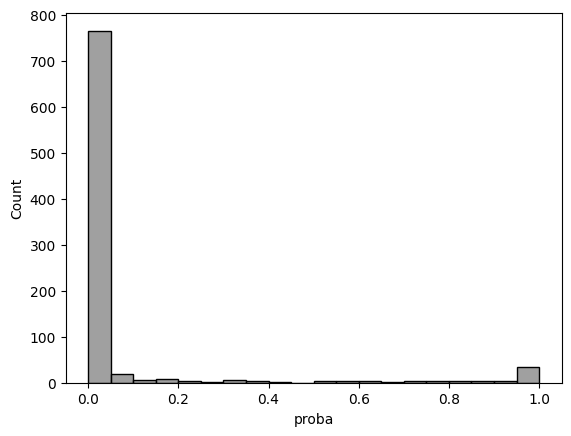

In [291]:
proba = pd.DataFrame(columns=['proba'], data=test_run['model'].best_estimator_[1].predict_proba(test_run['Z_test'])[:, 1])
#proba['validation'] = test_run['Y']
#sns.histplot(data=proba[proba['validation']==1], x="proba", color='orange')
sns.histplot(data=proba, x="proba", bins=20, color='grey')



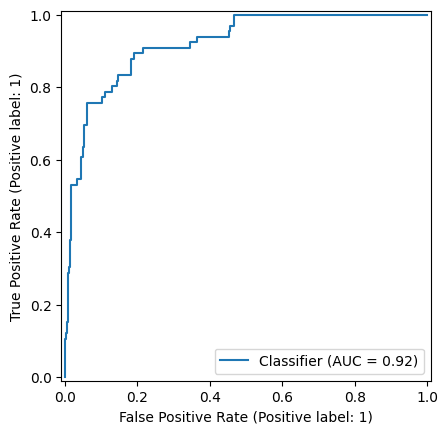

In [41]:
RocCurveDisplay.from_predictions(test_run['Y'], test_run['Yhat'][:,1])
#plt.show()

In [42]:
# aggregate shap values on 20% holdout set
explainer = shap.TreeExplainer(test_run['model'].best_estimator_[1])
labels = test_run['features']['cont'] + list(test_run['model'].best_estimator_[0]['cat_cap'].categories_[0]) +  test_run['features']['bin']
X_test = pd.DataFrame(columns=labels, data=test_run['model'].best_estimator_[0].transform(test_run['X']))
shap_values = explainer(X_test)
#shap.summary_plot(shap_values, X_test, max_display=30)

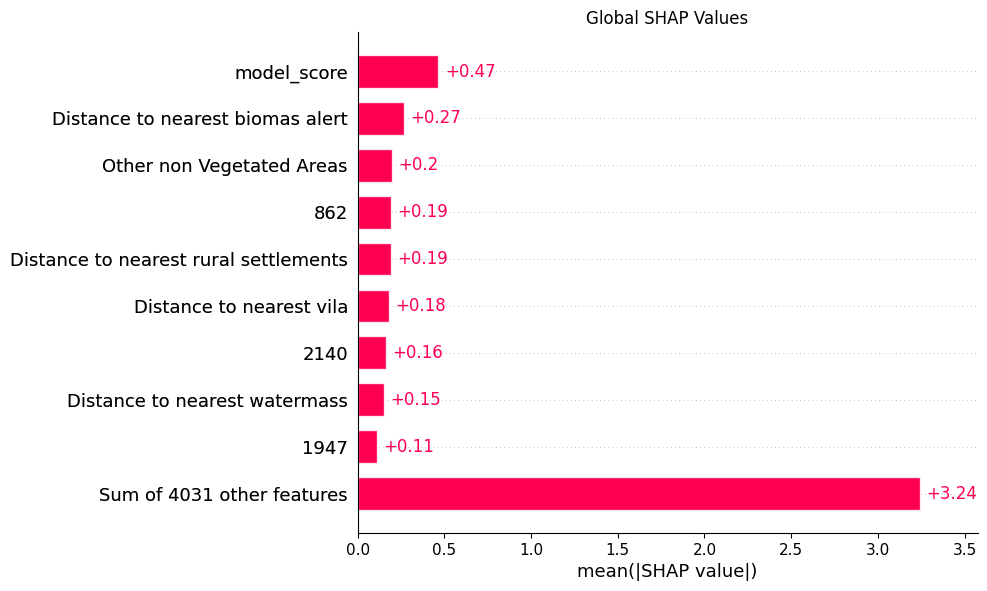

In [43]:
shap.plots.bar(shap_values, show=False)
#plt.savefig("shap_summary.png",dpi=600, transparent=True, bbox_inches='tight') #.png,.pdf will also support here
plt.title("Global SHAP Values")
plt.show()

<Axes: >

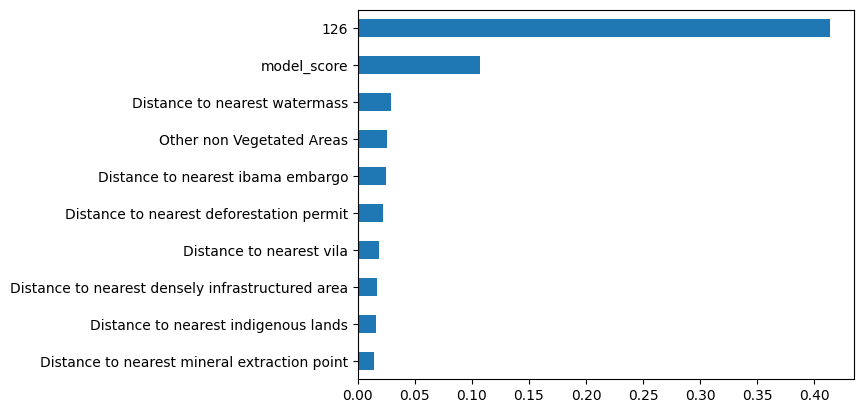

In [298]:
# built-in feature importance from gradient boost classifier
labels = test_run['features']['cont'] + list(test_run['model'].best_estimator_[0]['cat_cap'].categories_[0]) +  test_run['features']['bin']

pd.DataFrame(index = labels, data= test_run['model'].best_estimator_[1].feature_importances_).sort_values(by=0, ascending=False)[:10].sort_values(by=0).plot.barh(legend=False)
#plt.savefig('feature_importance.png', transparent=True, dpi=600, bbox_inches='tight')